In [1]:
seed = 123

In [2]:
from shutil import copyfile

copyfile(
    src = "/kaggle/input/bdc-p53/p53_helper_functions.py", 
    dst = "/kaggle/working/p53_helpers.py"
)

from p53_helpers import *

# load dataset (no NAs)
X, Y = load_p53_ds()
# sratified 80/20 split
X_train, X_test, Y_train, Y_test = split_p53(X, Y)

Using TensorFlow backend.



Import completed after 3.7 sec

CLASS RATIOS
Training set active classes:   121/24927 (0.485 %)
Test set active classes:       30/6232 (0.481 %)

MATRIX DIMENSIONS
TRAINING SET
. Features:   (24927, 5408)
. Classes:    (24927,)
TEST SET
. Features:   (6232, 5408)
. Classes:    (6232,)


In [3]:
# make model and return the prop of the minority class to allow optimization the class weights
def make_model(
    x, y,
    u1=256,
    d1=0.5,
    lr=0.001,
    smart_init=True
):
    
    # define metrics
    metrics = [
        mcc,
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc', curve="PR")
    ]
    
    if smart_init:
        n_active = y.sum()
        n_inactive = len(y) - n_active
        b0 = tf.keras.initializers.Constant(np.log([n_active / n_inactive]))
    else:
        b0=None # random initialization

    # build & compile
    model = keras.Sequential([
        keras.layers.Dense(u1, activation='relu', input_shape=(x.shape[-1], )),
        keras.layers.Dropout(d1),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=b0)
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(lr=lr),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )
    
    return model

In [4]:
# early stopping criteria
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mcc',
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True
)

In [5]:
X_train, Y_train = np.array(X_train), np.array(Y_train)

tic = time.time()
# Preprocessing
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clip", ClipFeatures(c=3))
])

X_train_prepped = pipe.fit_transform(X_train, Y_train)

print("Preprocessing:", round(time.time() - tic), "sec")

# transform test set

# X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test_prepped = pipe.transform(X_test)

Preprocessing: 4 sec


In [6]:
# helper function for model evaluation
def eval_on_test(model, X_test_prepped=X_test_prepped, Y_test=Y_test):
    
    Y_test_proba = model.predict_proba(X_test_prepped)
    Y_pred = (Y_test_proba > 0.5).astype('int')
    prec, rec, t = precision_recall_curve(Y_test, Y_test_proba)

    print(f"Model 1\n{'-' * 80}")
    print(f"Precision:     {precision_score(Y_test, Y_pred):.2%}")
    print(f"Recall:        {recall_score(Y_test, Y_pred):.2%}")
    print(f"AUCPR:         {auc(rec, prec):.2%}")
    print(f"F1:            {f1_score(Y_test, Y_pred):.2%}")
    print(f"MCC:           {matthews_corrcoef(Y_test, Y_pred):.2%}")
    print()

    plt.plot(rec, prec, marker='.', label="m1", alpha=0.5)

# Evaluate RFC pipelines

Compare:
    * m1: Resampling
    * m2: Resampling w/ cost-sensitive learning
    * m3: No resampling
    * m4: No resampling w/ cost-sensitive learning
    * m5: No preprocessing

In [7]:
# partition training set for early stopping
X_t, X_v, Y_t, Y_v = train_test_split(X_train_prepped, Y_train, test_size=0.25, random_state=123, stratify=Y_train)

# upsample train/val split => X_t_rs/Y_t_rs
upsampler = SVMSMOTE(sampling_strategy=0.20, random_state=seed, k_neighbors=10, m_neighbors=10)
X_t_rs, Y_t_rs = upsampler.fit_resample(X_t, Y_t)

# upsample entire training set => X_train_rs/Y_train_rs
upsampler = SVMSMOTE(sampling_strategy=0.20, random_state=seed, k_neighbors=10, m_neighbors=10)
X_train_rs, Y_train_rs = upsampler.fit_resample(X_train_prepped, Y_train)

# Model 1: Resampling, no CSL

In [8]:
# Model 1: resampling
m1 = make_model(x=X_t_rs, y=Y_t_rs, lr=0.001)

m1_history = m1.fit(
    X_t_rs,
    Y_t_rs,
    batch_size=4096,
    epochs=75,
    callbacks=[early_stopping],
    validation_data=(X_v, Y_v),
    verbose=0
)

EPOCH = m1_history.epoch[-1] + 1

Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping


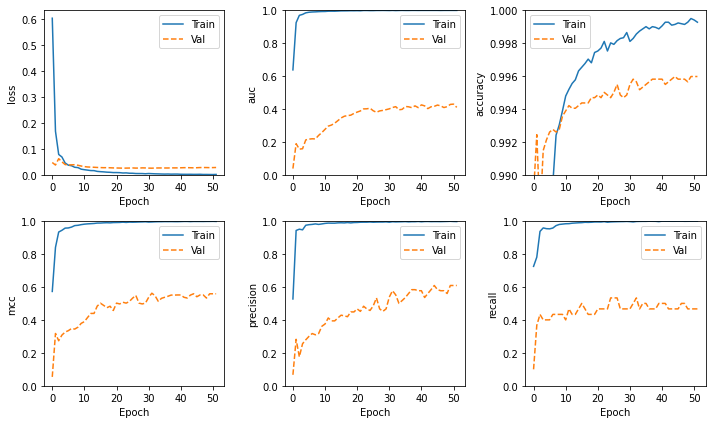

In [9]:
plot_history(m1_history)

In [10]:
# refit on entire training set
tic = time.time()

m1 = make_model(x=X_train_rs, y=Y_train_rs, lr=0.001)

m1_history = m1.fit(
    X_train_rs,
    Y_train_rs,
    batch_size=4096,
    epochs=EPOCH,
    verbose=0
)

print("Training time", round(time.time() - tic), "sec")

Training time 94 sec


Model 1
--------------------------------------------------------------------------------
Precision:     73.33%
Recall:        73.33%
AUCPR:         71.66%
F1:            73.33%
MCC:           73.20%



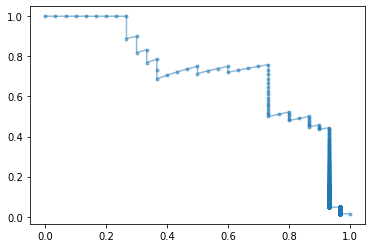

In [11]:
# evaluate on held-out test set
eval_on_test(m1)

# Model 2: Resampling + CSL

Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping


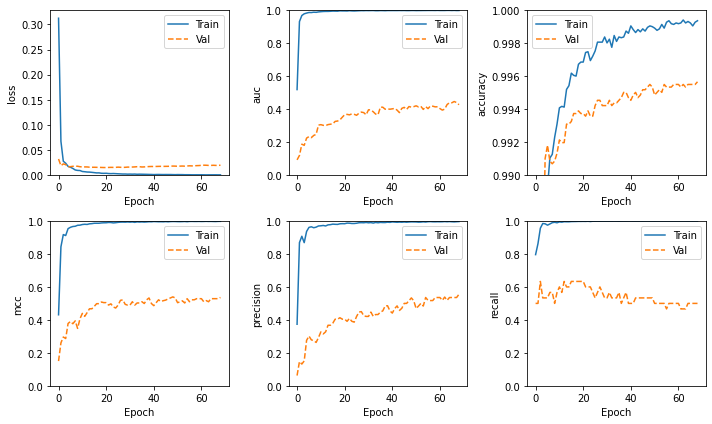

In [12]:
# Model 2: Resampling + CSL
m2 = make_model(x=X_t_rs, y=Y_t_rs, lr=0.001)
cw = {0:0.20, 1:0.80}

m2_history = m2.fit(
    X_t_rs,
    Y_t_rs,
    batch_size=4096,
    epochs=75,
    callbacks=[early_stopping],
    validation_data=(X_v, Y_v),
    verbose=0,
    class_weight=cw
)

EPOCH = m2_history.epoch[-1] + 1

plot_history(m2_history)

In [13]:
# refit on entire (resampled) training data
tic = time.time()

m2 = make_model(x=X_train_rs, y=Y_train_rs, lr=0.001)

m2_history = m2.fit(
    X_train_rs,
    Y_train_rs,
    batch_size=4096,
    epochs=EPOCH,
    verbose=0,
    class_weight=cw
)

print("Training time", round(time.time() - tic), "sec")

Training time 135 sec


Model 1
--------------------------------------------------------------------------------
Precision:     63.89%
Recall:        76.67%
AUCPR:         71.23%
F1:            69.70%
MCC:           69.83%



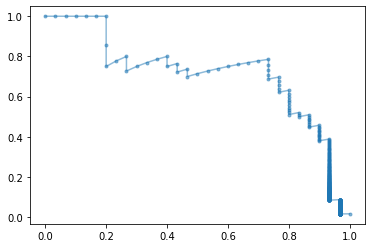

In [14]:
# evaluate on test set
eval_on_test(m2)

# Model 3: No resampling, no CSL

Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping


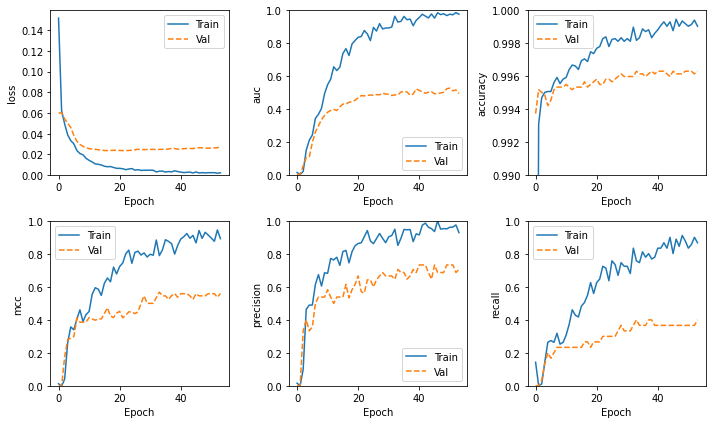

In [15]:
# Model 3: No resampling, no CSL
m3 = make_model(x=X_t, y=Y_t, lr=0.001) # non-resampled training folds

m3_history = m3.fit(
    X_t,
    Y_t,
    batch_size=4096,
    epochs=75,
    callbacks=[early_stopping],
    validation_data=(X_v, Y_v), 
    verbose=0
)

EPOCH = m3_history.epoch[-1] + 1

plot_history(m3_history)

In [16]:
# refit on entire training set
tic = time.time()

m3 = make_model(x=X_train_prepped, y=Y_train, lr=0.001)

m3_history = m3.fit(
    X_train_prepped,
    Y_train,
    batch_size=4096,
    epochs=EPOCH,
    verbose=0
)

print("Training time", round(time.time() - tic), "sec")

Training time 83 sec


Model 1
--------------------------------------------------------------------------------
Precision:     67.86%
Recall:        63.33%
AUCPR:         71.47%
F1:            65.52%
MCC:           65.40%



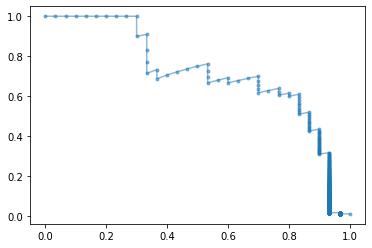

In [17]:
eval_on_test(m3)

# Model 4: No resampling + CSL

Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping


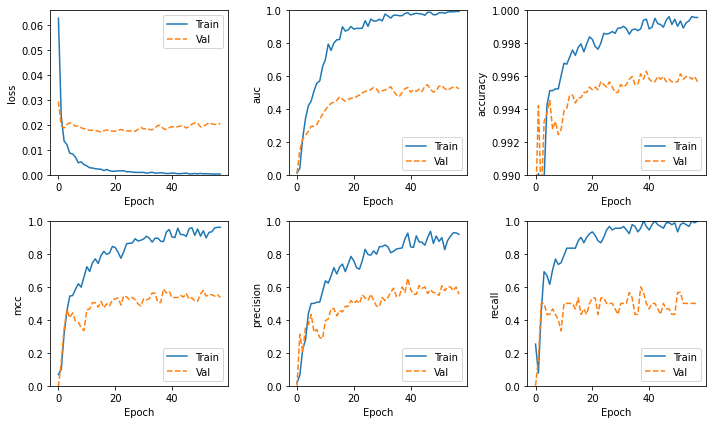

In [18]:
# Model 4: No resampling, CSL

m4 = make_model(x=X_t, y=Y_t, lr=0.001) # non-resampled training folds

cw = {0: 0.15, 1: 0.85}

m4_history = m4.fit(
    X_t,
    Y_t,
    batch_size=4096,
    epochs=75,
    callbacks=[early_stopping],
    validation_data=(X_v, Y_v), 
    verbose=0,
    class_weight=cw
)

EPOCH = m4_history.epoch[-1] + 1

plot_history(m4_history)

In [19]:
# refit on entire training set
tic = time.time()

m4 = make_model(x=X_train_prepped, y=Y_train, lr=0.001)

m4_history = m4.fit(
    X_train_prepped,
    Y_train,
    batch_size=4096,
    epochs=EPOCH,
    verbose=0,
    class_weight=cw
)

print("Training time", round(time.time() - tic), "sec")

Training time 89 sec


Model 1
--------------------------------------------------------------------------------
Precision:     70.59%
Recall:        80.00%
AUCPR:         70.59%
F1:            75.00%
MCC:           75.02%



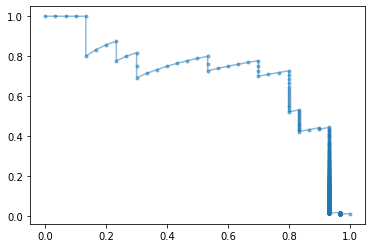

In [20]:
eval_on_test(m4)

# Model 5: baseline, no PP, resampling, CSL

In [21]:
# partition train/val (no PP)
X_t, X_v, Y_t, Y_v = train_test_split(X_train, Y_train, test_size=0.25, random_state=seed, stratify=Y_train)

Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
60


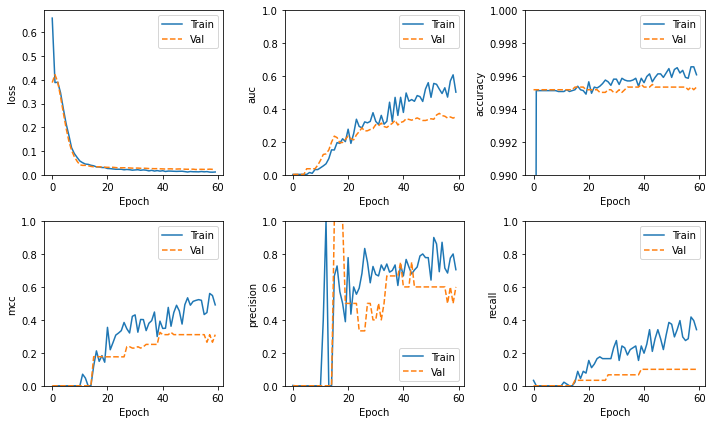

In [22]:
# Model 5: no pp
m5 = make_model(x=X_t, y=Y_t, lr=0.001)

m5_history = m5.fit(
    X_t,
    Y_t,
    batch_size=4096,
    epochs=75,
    callbacks=[early_stopping],
    validation_data=(X_v, Y_v), 
    verbose=0
)

EPOCH = m5_history.epoch[-1] + 1
print(EPOCH)

plot_history(m5_history)

In [23]:
# refit on entire training set
tic = time.time()

m5 = make_model(x=X_train, y=Y_train, lr=0.001)

m5_history = m5.fit(
    X_train,
    Y_train,
    batch_size=4096,
    epochs=EPOCH,
    verbose=0
)

print("Training time", round(time.time() - tic), "sec")

Training time 92 sec


Model 1
--------------------------------------------------------------------------------
Precision:     70.00%
Recall:        23.33%
AUCPR:         51.63%
F1:            35.00%
MCC:           40.27%



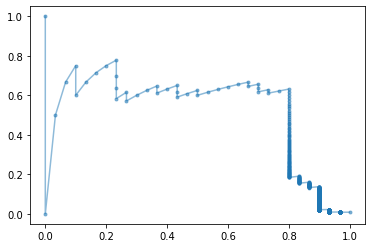

In [24]:
eval_on_test(m5, X_test_prepped=X_test)

# Collect results for visualization

Resampling - No CSL
--------------------------------------------------------------------------------
Precision:     73.33%
Recall:        73.33%
AUCPR:         71.66%
F1:            73.33%
MCC:           73.20%

Resampling - CSL
--------------------------------------------------------------------------------
Precision:     63.89%
Recall:        76.67%
AUCPR:         71.23%
F1:            69.70%
MCC:           69.83%

No Resampling - No CSL
--------------------------------------------------------------------------------
Precision:     67.86%
Recall:        63.33%
AUCPR:         71.47%
F1:            65.52%
MCC:           65.40%

No Resampling - CSL
--------------------------------------------------------------------------------
Precision:     70.59%
Recall:        80.00%
AUCPR:         70.59%
F1:            75.00%
MCC:           75.02%

NN (no PP)
--------------------------------------------------------------------------------
Precision:     70.00%
Recall:        23.33%
AUCPR:         5

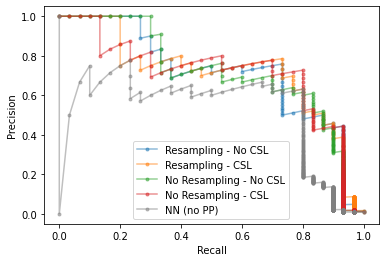

In [25]:
# init dfs for results
out_curves = pd.DataFrame(
    columns=["model", "precision", "recall", "threshold"]
)

out_eval = pd.DataFrame(
    index=np.arange(5), 
    columns=["model", "precision", "recall", "accuracy", "balanced_accuracy", "f1", "mcc", "tn", "fp", "fn", "tp", "aucpr"]
)

i = 0

for name, model in zip(
    ["Resampling - No CSL", "Resampling - CSL", "No Resampling - No CSL", "No Resampling - CSL"],
    [m1, m2, m3, m4]
):

    Y_test_proba = model.predict_proba(X_test_prepped)    # estimated P(class == "active")
    Y_pred = (Y_test_proba > 0.5).astype('int')           # predicted class labels

    # construct precision-recall curve
    prec, rec, t = precision_recall_curve(Y_test, Y_test_proba)
    plt.plot(rec, prec, marker='.', label=name, alpha=0.5)
    
    t = np.append(t, t[-1])
    
    curves = pd.DataFrame({
        "model": name,
        "precision": prec,
        "recall": rec,
        "threshold": t
    })
    
    out_curves = out_curves.append(curves)

    # compute eval metrics
    scores = [
        scorer(Y_test, Y_pred) for scorer in [            
            precision_score, recall_score, accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef
        ]
    ]
    
    # add tn, fp, fn, tp
    scores.extend(confusion_matrix(Y_test, Y_pred).ravel())
    # add AUCPR
    scores.append(auc(rec, prec))
    # add name
    scores.insert(0, name)
    
    # store in df
    for col, value in zip(out_eval.columns, scores):
        out_eval[col][i] = value
    
    i += 1
    
    # print evaluation scores
    print(f"{name}\n{'-' * 80}")
    print(f"Precision:     {precision_score(Y_test, Y_pred):.2%}")
    print(f"Recall:        {recall_score(Y_test, Y_pred):.2%}")
    print(f"AUCPR:         {auc(rec, prec):.2%}")
    print(f"F1:            {f1_score(Y_test, Y_pred):.2%}")
    print(f"MCC:           {matthews_corrcoef(Y_test, Y_pred):.2%}")
    print()

# add m5: reference (on unprocessed ds)

name = "NN (no PP)"
Y_test_proba = m5.predict_proba(X_test)                   # estimated P(class == "active")
Y_pred = (Y_test_proba > 0.5).astype('int')               # predicted class labels

# construct precision-recall curve
prec, rec, t = precision_recall_curve(Y_test, Y_test_proba)
plt.plot(rec, prec, marker='.', label=name, alpha=0.5, c="grey")

t = np.append(t, t[-1])

curves = pd.DataFrame({
    "model": name,
    "precision": prec,
    "recall": rec,
    "threshold": t
})

out_curves = out_curves.append(curves)

# compute eval metrics
scores = [
    scorer(Y_test, Y_pred) for scorer in [            
        precision_score, recall_score, accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef
    ]
]

# add tn, fp, fn, tp
scores.extend(confusion_matrix(Y_test, Y_pred).ravel())
# add AUCPR
scores.append(auc(rec, prec))
# add name
scores.insert(0, name)

# store in df
for col, value in zip(out_eval.columns, scores):
    out_eval[col][4] = value

# print evaluation scores
print(f"{name}\n{'-' * 80}")
print(f"Precision:     {precision_score(Y_test, Y_pred):.2%}")
print(f"Recall:        {recall_score(Y_test, Y_pred):.2%}")
print(f"AUCPR:         {auc(rec, prec):.2%}")
print(f"F1:            {f1_score(Y_test, Y_pred):.2%}")
print(f"MCC:           {matthews_corrcoef(Y_test, Y_pred):.2%}")
print()

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

In [26]:
out_eval.to_csv("NN_eval.csv")
out_curves.to_csv("NN_eval_PRcurves.csv")